In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
'''!pip install kaggle'''

'!pip install kaggle'

In [3]:
'''import os
import shutil

# Correct destination folder
destination = "C:/Users/Akanksha/.kaggle"

# Create folder if it doesn't exist
os.makedirs(destination, exist_ok=True)

# Move kaggle.json to that folder
shutil.move("kaggle.json", os.path.join(destination, "kaggle.json"))'''

'import os\nimport shutil\n\n# Correct destination folder\ndestination = "C:/Users/Akanksha/.kaggle"\n\n# Create folder if it doesn\'t exist\nos.makedirs(destination, exist_ok=True)\n\n# Move kaggle.json to that folder\nshutil.move("kaggle.json", os.path.join(destination, "kaggle.json"))'

In [4]:
'''!kaggle datasets list -s "nyc taxi"'''

'!kaggle datasets list -s "nyc taxi"'

## Data

In [6]:
'''! kaggle competitions download -c new-york-city-taxi-fare-prediction'''

'! kaggle competitions download -c new-york-city-taxi-fare-prediction'

In [7]:
'''import zipfile

with zipfile.ZipFile("new-york-city-taxi-fare-prediction.zip", "r") as zip_ref:
    zip_ref.extractall("nyc_taxi_data")'''

'import zipfile\n\nwith zipfile.ZipFile("new-york-city-taxi-fare-prediction.zip", "r") as zip_ref:\n    zip_ref.extractall("nyc_taxi_data")'

In [8]:
import os

os.listdir("nyc_taxi_data")

['GCP-Coupons-Instructions.rtf',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [9]:
import pandas as pd

df = pd.read_csv("nyc_taxi_data/train.csv", nrows=50000)  
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [10]:
#  0 = low fare, 1 = medium, 2 = high
def classify_fare(fare):
    if fare <= 7:
        return 0
    elif fare <= 15:
        return 1
    else:
        return 2

df["fare_class"] = df["fare_amount"].apply(classify_fare)

## Haversine formula to calculate distance travelled

In [12]:
 def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS 
coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers
    return d

In [13]:
 df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
 df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_class,dist_km
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0,1.999157


In [14]:
df['ISTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) + pd.Timedelta(hours=5, minutes=30)
df['Hour'] = df['ISTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['ISTdate'].dt.strftime("%a")
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_class,dist_km,ISTdate,Hour,AMorPM,Weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0,1.030764,2009-06-15 22:56:21,22,pm,Mon
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2,8.450134,2010-01-05 22:22:16,22,pm,Tue
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0,1.389525,2011-08-18 06:05:00,6,am,Thu
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,1,2.799270,2012-04-21 10:00:42,10,am,Sat
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0,1.999157,2010-03-09 13:21:00,13,pm,Tue


In [15]:
print(df['ISTdate'].min())
print(df['ISTdate'].max())

2009-01-01 07:01:49
2015-07-01 04:12:39


In [16]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'fare_class', 'dist_km', 'ISTdate', 'Hour', 'AMorPM',
       'Weekday'],
      dtype='object')

In [17]:
cat_cols = ['Hour', 'AMorPM','Weekday']
cont_cols = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count', 'dist_km']
y_col = ['fare_amount']

In [18]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
   df[cat] = df[cat].astype('category')

In [19]:
df.dtypes

key                          object
fare_amount                 float64
pickup_datetime              object
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
fare_class                    int64
dist_km                     float64
ISTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [20]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [21]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values
cats = np.stack([hr, ampm, wkdy], 1)
cats[:5]

array([[22,  1,  1],
       [22,  1,  5],
       [ 6,  0,  4],
       [10,  0,  2],
       [13,  1,  5]], dtype=int8)

In [22]:
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

tensor([[22,  1,  1],
        [22,  1,  5],
        [ 6,  0,  4],
        [10,  0,  2],
        [13,  1,  5]])

In [23]:
# continuous variable to tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[-73.8443,  40.7213, -73.8416,  40.7123,   1.0000,   1.0308],
        [-74.0160,  40.7113, -73.9793,  40.7820,   1.0000,   8.4501],
        [-73.9827,  40.7613, -73.9912,  40.7506,   2.0000,   1.3895],
        [-73.9871,  40.7331, -73.9916,  40.7581,   1.0000,   2.7993],
        [-73.9681,  40.7680, -73.9567,  40.7838,   1.0000,   1.9992]])

In [24]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y[:5]

tensor([[ 4.5000],
        [16.9000],
        [ 5.7000],
        [ 7.7000],
        [ 5.3000]])

In [25]:
print(cats.shape)
print(conts.shape)
print(y.shape)

torch.Size([50000, 3])
torch.Size([50000, 6])
torch.Size([50000, 1])


## Embedding

In [27]:
#The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## TabularModel

In [29]:
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum(( nf for ni, nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [30]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.7)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.7, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.7, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## loss function & optimizer

In [32]:
criterion = nn.MSELoss()  # converted to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## train/test splits

In [34]:
batch_size = 25000
test_size = int(batch_size * .2)
cat_train = cats[:batch_size-test_size]   # slicing array[start:stop]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [35]:
print(len(cat_train))
print(len(cat_test))

20000
5000


##  Train the model

In [37]:
import time
start_time = time.time()
epochs = 550
losses = []
for i in range(epochs):
   i+=1
   y_pred = model(cat_train, con_train)
   loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
   losses.append(loss)
   
   # a neat trick to save screen space:
   if i%25 == 1:
       print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed



epoch:   1  loss: 14.85822392
epoch:  26  loss: 14.73277187
epoch:  51  loss: 14.57348633
epoch:  76  loss: 14.24924088
epoch: 101  loss: 13.70878410
epoch: 126  loss: 13.03833866
epoch: 151  loss: 12.26437759
epoch: 176  loss: 11.49577713
epoch: 201  loss: 10.85832214
epoch: 226  loss: 10.51042843
epoch: 251  loss: 10.34716511
epoch: 276  loss: 10.13806057
epoch: 301  loss: 10.10060501
epoch: 326  loss: 10.06693077
epoch: 351  loss: 10.03997803
epoch: 376  loss: 9.92752457
epoch: 401  loss: 9.92704391
epoch: 426  loss: 9.89271927
epoch: 451  loss: 9.91149044
epoch: 476  loss: 9.86094666
epoch: 501  loss: 9.83688927
epoch: 526  loss: 9.81600952
epoch: 550  loss: 9.79519176

Duration: 271 seconds


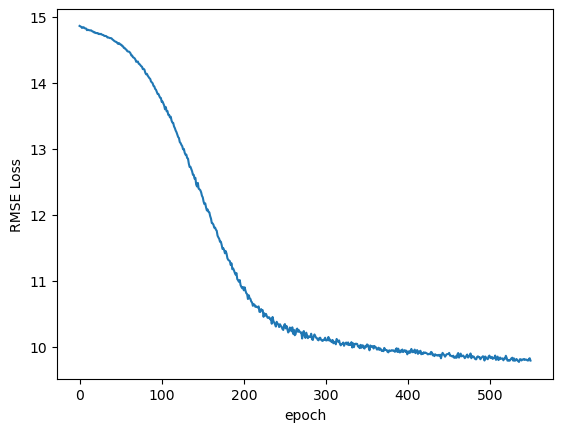

In [38]:
plt.plot(range(epochs), [loss.detach().item() for loss in losses])
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Validate the model

In [40]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
   y_val = model(cat_test, con_test)
   loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 9.70723724


In [41]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
   diff = np.abs(y_val[i].item()-y_test[i].item())
   print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.  15.0702  17.0000   1.9298
 2.   8.9883  10.5000   1.5117
 3.  14.1353   6.0000   8.1353
 4.  14.3395  16.5000   2.1605
 5.  14.0095   6.5000   7.5095
 6.   9.7813  11.0000   1.2187
 7.   6.9159  49.8000  42.8841
 8.  10.1465  10.1000   0.0465
 9.  12.5859  16.5000   3.9141
10.  11.7922   5.3000   6.4922
11.   9.2481   5.3000   3.9481
12.  10.0303  10.1000   0.0697
13.  13.8367  24.5000  10.6633
14.   7.8594  14.0000   6.1406
15.   8.7733  10.0000   1.2267
16.  13.8994   8.9000   4.9994
17.   9.7705   6.9000   2.8705
18.  11.5516  10.9000   0.6516
19.  15.2500   5.3000   9.9500
20.   9.7065  14.0000   4.2935
21.  10.8582  20.9000  10.0418
22.  12.9820   9.3000   3.6820
23.  11.6961   7.3000   4.3961
24.  11.5089   8.5000   3.0089
25.   5.5984   6.0000   0.4016
26.   8.7580   5.0000   3.7580
27.  13.5973   5.0000   8.5973
28.   8.7204   9.7000   0.9796
29.  12.4993  12.5000   0.0007
30.   8.6198   4.5000   4.1198
31.   7.3403   5.3000   2.0403
32.  13.

In [42]:
model_regr = model  

# Classification

## function & optimizer

In [172]:
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Train the model

In [47]:
y1_col = df['fare_class']

In [48]:
y1_col[:5]

0    0
1    2
2    0
3    1
4    0
Name: fare_class, dtype: int64

In [49]:
y1_col = torch.tensor(y1_col.values).flatten()
y1_col[:5]

tensor([0, 2, 0, 1, 0])

## train/test splits for y1

In [51]:
y1_col_train = y1_col[:batch_size-test_size]
y1_col_test = y1_col[batch_size-test_size:batch_size]

In [52]:
print(y1_col_train)
print(y1_col_test)

tensor([0, 2, 0,  ..., 2, 1, 1])
tensor([2, 1, 0,  ..., 1, 2, 1])


In [170]:
model = TabularModel(emb_szs, conts.shape[1], 3, [200, 100], p=0.5)

In [174]:
start_time = time.time()
epochs = 300
losses2 = []
for i in range(epochs):
   
   y_pred = model(cat_train, con_train)
   y_pred = y_pred.float()   
   loss2 = criterion2(y_pred, y1_col_train) 
   losses2.append(loss2)
   
   # a neat trick to save screen space:
   if i%25 == 1:
       print(f'epoch: {i:3}  loss: {loss2.item():10.8f}')
   optimizer.zero_grad()
   loss2.backward()
   optimizer.step()
print(f'epoch: {i:3}  loss: {loss2.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 1.29731762
epoch:  26  loss: 1.04038525
epoch:  51  loss: 1.03552842
epoch:  76  loss: 1.03555560
epoch: 101  loss: 1.02779460
epoch: 126  loss: 0.77797425
epoch: 151  loss: 0.63367957
epoch: 176  loss: 0.58443201
epoch: 201  loss: 0.56863916
epoch: 226  loss: 0.55713362
epoch: 251  loss: 0.55042094
epoch: 276  loss: 0.54636747
epoch: 299  loss: 0.53951865

Duration: 42 seconds


##  Plot the loss function

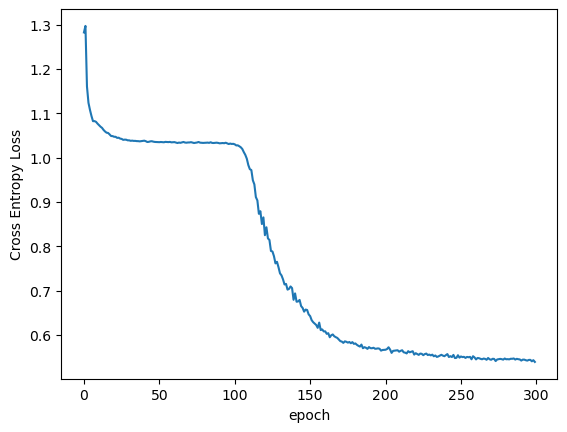

In [176]:
plt.plot(range(epochs), [loss2.detach().item() for loss2 in losses2])
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

## Validate the model

In [178]:
 # TO EVALUATE THE ENTIRE TEST SET
 with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
 print(f'CE Loss: {loss:.8f}')

CE Loss: 222.12234497


C:\Users\Akanksha\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([5000, 1])) that is different to the input size (torch.Size([5000, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
